In [22]:
from random import random, seed, randrange
from math import floor, pi
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import pandas as pd
from scipy.integrate import simps, trapz, cumtrapz
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 9]

In [23]:
def load_co( Nco, s_box, N_max ):
    
    Xco = [0]*N_max; Yco =[0]*N_max; Zco =[0]*N_max;
    for i in range(Nco ):
        Xco[i] = random()*s_box #[A]
        Yco[i] = random()*s_box #[A]
        Zco[i] = random()*s_box #[A]
    return Xco, Yco, Zco   

def load_me( Nme, s_box, N_max ):
    
    Xme = [0]*N_max; Yme =[0]*N_max; Zme =[0]*N_max;
    for i in range( Nme ):
        Xme[i] = random()*s_box #[A]
        Yme[i] = random()*s_box #[A]
        Zme[i] = random()*s_box #[A]
    return Xme, Yme, Zme   

def load_c( Nc, s_box):
    Xc = [0]*Nc; Yc =[0]*Nc; Zc =[0]*Nc;
    for i in range( Nc ):
        Xc[i] = random()*s_box #[A]
        Yc[i] = random()*s_box #[A]
        Zc[i] = random()*s_box #[A]
    return Xc, Yc, Zc   

def move(spec, o, x, y, z):
    # Carry out the "move" trial move
    if( spec == "co2"): 
        Xco[o] = x
        Yco[o] = y
        Zco[o] = z
        
    elif (spec == "me"):
        Xme[o] = x
        Yme[o] = y
        Zme[o] = z
    
    
def add(spec, x, y, z):
    # Carry out the "add" trial move
    global Nco, Nme
    if( spec == "co2"): 
        Xco[Nco] = x
        Yco[Nco] = y
        Zco[Nco] = z
        Nco = Nco + 1
        
    elif (spec == "me"):
        Xme[Nme] = x
        Yme[Nme] = y
        Zme[Nme] = z
        Nme = Nme + 1
    
    
def remove(spec, o):
    # Carry out the "remove" trial move
    global Nco, Nme
    if( spec == "co2"): 
        Nco = Nco - 1
        Xco[o] = Xco[Nco]
        Yco[o] = Yco[Nco]
        Zco[o] = Zco[Nco]
        
    elif (spec == "me"):
        Nme = Nme - 1
        Xme[o] = Xme[Nme]
        Yme[o] = Yme[Nme]
        Zme[o] = Zme[Nme]
        
    


def dist_hi(spec,x,y,z,j):
    # Distance btw a proposed particle and the ith H2 particle
    if(spec == "co2"):
        dx = x - Xco[j] #[A]
        dy = y - Yco[j] #[A]
        dz = z - Zco[j] #[A]
    elif (spec == "me"):
        dx = x - Xme[j] #[A]
        dy = y - Yme[j] #[A]
        dz = z - Zme[j] #[A]

    if (dx > 0.5*s_box):
        dx = dx-s_box 
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz

def dist_ci(x,y,z,j):
    # Distance btw proposed particle and the ith C particle
    dx = x - Xc[j] #[A]
    dy = y - Yc[j] #[A]
    dz = z - Zc[j] #[A]
    if (dx > 0.5*s_box):
        dx = dx-s_box
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz



def Ui(r2, eps, sig):
    # LJ potential btw two particles at r distance away
    if ( r2 < rc*rc ):
        r2i = sig*sig/r2 #[]
        r6i = r2i*r2i*r2i
        ui = 4*eps*(r6i*r6i-r6i) #[K]
        fi = 48*eps*(r6i*r6i-0.5*r6i) #[K]
    else:
        ui = 0
        fi = 0
    return ui, fi

def Up(spec, x, y, z, ia, jb=0):
    # Total LJ potential of proposed particle with all other particles
    # omit the ia'th H2 particle. When not needed, Nh is used.
    # jb used in the UTo operation to avoid overcounting interactions
    U_move = 0
    F_move = 0
    
    if(spec == "co2"):
        #Similar Particles
        for i in range(jb, Nco): # H2 particles
            if ( i != ia):
                r2 = dist_hi("co2", x,y,z, i)
                ui, fi = Ui( r2, e_co, s_co)
                U_move = U_move + ui
                F_move = F_move + fi
        #Other Mobile
        
        for i2 in range(0,Nme):
            r2 = dist_hi("me", x,y,z, i2)
            ui, fi = Ui( r2, e_meco, s_meco)
            U_move = U_move + ui
            F_move = F_move + fi
        
        for ic in range(Nc): # C particles
            r2 = dist_ci( x,y,z, ic)
            ui, fi = Ui( r2, e_cco, s_cco)
            U_move = U_move + ui
            F_move = F_move + fi
        
    elif (spec == "me"):
        #Similar Particles
        for i in range(jb, Nme): # H2 particles
            if ( i != ia):
                r2 = dist_hi("me", x,y,z, i)
                ui, fi = Ui( r2, e_me, s_me)
                U_move = U_move + ui
                F_move = F_move + fi
        #Other Mobile
        
        for i2 in range(0,Nco):
            r2 = dist_hi("co2", x,y,z, i2)
            ui, fi = Ui( r2, e_meco, s_meco)
            U_move = U_move + ui
            F_move = F_move + fi
        
        for ic in range(Nc): # C particles
            r2 = dist_ci( x,y,z, ic)
            ui, fi = Ui( r2, e_cme, s_cme)
            U_move = U_move + ui
            F_move = F_move + fi
                 
    return U_move, F_move

def p_rem(spec, U_move ):
    # Acceptance probability of the "remove" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        if( spec == "co2"):
            return Nco*kb*np.exp( -beta*U_move )/(zz_co*Vol)
        else:
            return Nme*kb*np.exp( -beta*U_move)/(zz_me*Vol)
    
def p_add(spec, U_move ):
    # acceptance probability of the "add" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta > 100):
        return 1
    else:
        if( spec == "co2"):
            return zz_co*Vol*np.exp( -beta*U_move )/(Nco + 1)/kb
        else:
            return zz_me*Vol*np.exp( -beta*U_move )/(Nme + 1)/kb
    
def p_move( U_move ):
    # acceptance probability of the "move" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        return np.exp( -beta*U_move)
    
    
def U_Tot():
    UT = 0
    FT = 0

    # CO2 with CO2
    for j in range( 0, Nco ):
        for i in range( j, Nco):
            if ( i != j ):
                x = Xco[j]; y = Yco[j]; z = Zco[j]
                r2 = dist_hi("co2", x,y,z, i)
                ui, fi = Ui( r2, e_co, s_co)
                UT = UT + ui
                FT = FT + fi
    
    # Me with Me
    for j in range( 0, Nme ):
        for i in range( j, Nme):
            if ( i != j ):
                x = Xme[j]; y = Yme[j]; z = Zme[j]
                r2 = dist_hi("me", x,y,z, i)
                ui, fi = Ui( r2, e_me, s_me)
                UT = UT + ui
                FT = FT + fi

    # CO2 with Me
    for j in range( 0, Nco):
        for i in range( 0, Nme):
            x = Xco[j]; y = Yco[j]; z = Zco[j]
            r2 = dist_hi("me", x,y,z, i)
            ui, fi = Ui( r2, e_meco, s_meco)
            UT = UT + ui
            FT = FT + fi

    # CO2 with C
    for j in range( 0, Nco):
        for i in range( 0, Nc):
            x = Xco[j]; y = Yco[j]; z = Zco[j]
            r2 = dist_ci( x,y,z, i)
            ui, fi = Ui( r2, e_cco, s_cco)
            UT = UT + ui
            FT = FT + fi

    # Me with C
    for j in range( 0, Nme):
        for i in range( 0, Nc):
            x = Xme[j]; y = Yme[j]; z = Zme[j]
            r2 = dist_ci( x,y,z, i)
            ui, fi = Ui( r2, e_cme, s_cme)
            UT = UT + ui
            FT = FT + fi
    
    return( UT, FT )

def box_fix( x, y, z):
    # Correct for unit cell periodicity
    # Currently not used
    if x < 0:
        x = x + s_box
    if x > s_box:
        x = x - s_box
    if y < 0:
        y = y + s_box
    if y > s_box:
        y = y - s_box
    if z < 0:
        z = z + s_box
    if z > s_box:
        z = z - s_box
    return x,y,z


def mc_add():
    global UT, FT, Nco, Nme, Aacc, Aatt
    
    Aatt = Aatt + 1
    
    if ( random() < yco ):
        spec = "co2"
    else:
        spec = "me"
        
    x = random()*s_box
    y = random()*s_box
    z = random()*s_box
    
    U_move, F_move = Up(spec, x, y, z, N_max)
    
    pa_add = p_add(spec, U_move )
    
    if ( random() < pa_add):
        add(spec, x, y, z)
        UT = UT + U_move
        FT = FT + F_move
        Aacc = Aacc + 1
        if ( Nco > N_max | Nme > N_max ):
            return
            
def mc_remove():
    # Attempt a "remove" trial move
    global UT, FT, Nco, Nme, Ratt, Racc
    Ratt = Ratt + 1
    if (Nco <= 0 | Nme <= 0):
        return
    
    if ( random() < yco ):
        spec = "co2"
        o = floor( random()*Nco )
        x = Xco[o]
        y = Yco[o]
        z = Zco[o]
    else:
        spec = "me"
        o = floor( random()*Nme )
        x = Xme[o]
        y = Yme[o]
        z = Zme[o]
    
    
    # Calculate Energy of Trial Move
    U_move, F_move = Up(spec, x, y, z, o)
    U_move = -U_move
    F_move = -F_move

    
    # Probability of Accepting Trial Move
    pa_remove = p_rem(spec, U_move )
    
    # Accept or Decline Trial Move
    if (random() < pa_remove):
        try:
            remove(spec, o)
        except:
            print( "Spec", spec, "o", o, "Nco", Nco, "Nme", Nme)
            stop()
        UT = UT + U_move
        FT = FT + F_move
        Racc = Racc + 1
        if ( Nco > N_max | Nme > N_max ):
            return

def mc_move():
    # Attempt a "move" trial move
    global UT, FT, Nco, Nme, Nacc, Natt
    Natt = Natt + 1
    if (Nco == 0 | Nme == 0):
        return
    
    # Select Random particle
    if ( random() < yco ):
        spec = "co2"
        o = floor( random()*Nco )
        x = Xco[o]
        y = Yco[o]
        z = Zco[o]
    else:
        spec = "me"
        o = floor( random()*Nme )
        x = Xme[o]
        y = Yme[o]
        z = Zme[o]
    
    
    # Calculate Energy of current configuration
    U1, F1 = Up(spec, x,y,z, o)
    
    # Calculate new Location
    xn = x + delta*(random()-0.5)
    yn = y + delta*(random()-0.5)
    zn = z + delta*(random()-0.5)
    xn, yn, zn = box_fix( xn, yn, zn )
    
    # Calculate Energy of New Configuration
    U2, F2 = Up(spec, xn,yn,zn, o)
    U_move = U2 - U1
    F_move = F2 - F1
    
    pa_move = p_move( U_move )
        
    # Accept the trial move
    if ( random() < pa_move ):
        Nacc = Nacc + 1
        move(spec, o, xn, yn, zn)
        UT = UT + U_move
        FT = FT + F_move
        
def sample():
    rho_co = Nco/Vol
    rho_me = Nme/Vol
    if( floor(Nme + Nco) == 0):
        return 0, 0, 0, 0, 0, 0
    Enp = UT/(Nme + Nco)
    Pressure = ( Nco/Vol/beta + Nme/Vol/beta + FT/(3*Vol))*kb*10**(-6) #[MPa]
    return rho_co, rho_me, Enp, Pressure, Nco, Nme

def mc_step():
    # Perform one step of simulation
    if ( random() < pi_move ):
        mc_move()
    else:
        if ( random()< 0.5):
            mc_add()
        else:
            mc_remove()
            
def mc_cycle():
    # perform one cycle of simulation
    global Natt, Nacc, Aatt, Aacc, Ratt, Racc, delta
    rhocow=np.zeros(N_moves); rhomew=np.zeros(N_moves); 
    Enw=np.zeros(N_moves); Pw=np.zeros(N_moves);
    Ncow=np.zeros(N_moves);Nmew=np.zeros(N_moves)
    for i in range(N_moves):
        mc_step()
        rhocow[i], rhomew[i], Enw[i], Pw[i], Ncow[i], Nmew[i] = sample()
    adjust()
    return rhocow.mean(), rhomew.mean(), Enw.mean(), Pw.mean(), Ncow.mean(), Nmew.mean()

def adjust():
    # Change average "move" distance by acceptance history
    # Currently not being used
    global delta, Natt, Nacc
    if (Natt == 0 or Nacc > Natt):
        return
    else:
        frac = Nacc/Natt
        dro = delta
        delta = delta*abs(frac/0.5)
        if (delta/dro > 1.5 ):
            delta = dro*1.5
        if (delta/dro < 0.5):
            delta = dro*0.5
        if (delta > s_box*0.25):
            delta = s_box*0.25
        if (delta < s_box*0.01):
            delta = s_box*0.01
    return

def mc_run():
    # Perform simulation
    global Xco,Yco,Zco,Xme,Yme,Zme,Xc,Yc,Zc,Nc, UT, FT, Natt, Nacc, Aatt, Aacc, Ratt, Racc
    
    # Initialize Unit Cell
    Xco, Yco, Zco = load_co(Nco, s_box, N_max)
    Xme, Yme, Zme = load_me(Nme, s_box, N_max)
    Xc, Yc, Zc = load_c(Nc, s_box)
    UT, FT = U_Tot()
    
    
    # Equilibration Step
    Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0;
    for j in range(N_equil):
        mc_cycle()
        if( (j)%floor(N_equil/10) == 0 ):
            #print( j/N_equil )
            #print(j/N_equil, Nacc/Natt, Aacc/Aatt, Racc/Ratt)
            Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0 
            

    #Production Step
    rhocov=np.zeros(N_prod); rhomev=np.zeros(N_prod); 
    Env=np.zeros(N_prod); Pv=np.zeros(N_prod);
    Ncov=np.zeros(N_prod); Nmev=np.zeros(N_prod); 
    for j in range(N_prod):
        rhocov[j], rhomev[j], Env[j], Pv[j], Ncov[j], Nmev[j] = mc_cycle()
        if( (j)%floor(N_prod/10) == 0 ):
            print( j/N_prod )
            #print(j/N_prod, Nacc/Natt, Aacc/Aatt, Racc/Ratt)
            print(j, Ncov[j]/(Ncov[j]+Nmev[j]), Ncov[j] + Nmev[j], Pv[j], Env[j])
            Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0 
        
    #plt.plot( Pv )
    return rhocov,rhomev,Env,Pv,Ncov, Nmev



In [24]:
def kappa(ohm):
    return 0.37464 + 1.5422*ohm - 0.26992*ohm**2

def alpha(kappa, Tc, T):
    return ( 1 + kappa*(1 - np.sqrt(T/Tc) ) )**2

def a( Tc, Pc, alpha, P_res, T ):
    R = .08314 #L*bar/mol/K
    return 0.45724*R**2*Tc**2*alpha/Pc

def A( a, P_res, T ):
    R = .08314 #L*bar/mol/K
    return a*P_res/R**2/T**2

def b( Tc, Pc ):
    R = .08314 #L*bar/mol/K
    return 0.07780*R*Tc/Pc

def B( b, P_res, T):
    R = .08314 #L*bar/mol/K
    return b*P_res/R/T

def solveZ( A, B ):
    c1 = B-1
    c2 = A - 3*B**2 - 2*B
    c3 = B**3 + B**2 - A*B
    roots = np.roots( [1, c1, c2, c3] )
    for r in roots:
        if( r.imag == 0):
            return( r.real )
    else:
        stop()
        
        
def Fi( Aii, Ajj, Aij, A_mix, Bi, B_mix, Z_mix, yi, P_res ):
    term1 = Bi*(Z_mix - 1)/B_mix
    term2 = np.log( Z_mix - B_mix )
    term3 = A_mix/( 2*np.sqrt(2)*B_mix )
    term4 = 2*( yi*Aii + (1-yi)*Aij )/A_mix - Bi/B_mix
    term5 = (Z_mix + (1 + np.sqrt(2))*B_mix )/(Z_mix + (1 - np.sqrt(2))*B_mix )
    term6 = term1 - term2 - term3*term4*np.log( term5 )
    return yi*P_res*np.exp( term6 )

def Fone( Z, A, B, P_res):
    term1 = Z - 1 - np.log( Z - B)
    term2 = A/( 2*np.sqrt(2)*B )
    term3 = (Z + (1 + np.sqrt(2))*B )/(Z + (1 - np.sqrt(2))*B )
    term4 = term1 - term2*np.log( term3 )
    return np.exp( term4 )*P_res

def PR_Fugacity( P_res, T, yco):
    Tc_co = 304.2 #K
    Tc_me = 190.6 #K
    Pc_co = 73.76 #bar
    Pc_me = 46 #bar
    ohm_co = 0.225
    ohm_me = 0.008
    
    kappa_me = kappa( ohm_me )
    alpha_me = alpha( kappa_me, Tc_me, T)
    a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
    A_me = A( a_me, P_res, T )
    b_me = b( Tc_me, Pc_me )
    B_me = B( b_me, P_res, T)

    kappa_co = kappa( ohm_co )
    alpha_co = alpha( kappa_co, Tc_co, T)
    a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
    A_co = A( a_co, P_res, T )
    b_co = b( Tc_co, Pc_co )
    B_co = B( b_co, P_res, T)
    
    a_cm = np.sqrt(a_me*a_co )*(1-0.0919)
    A_cm = A( a_cm, P_res, T)

    a_mix = yco*yco*a_co + 2*yco*(1-yco)*a_cm + (1-yco)*(1-yco)*a_me
    b_mix = yco*b_co + (1-yco)*b_me

    A_mix = A( a_mix, P_res, T )
    B_mix = B( b_mix, P_res, T )
    Z_mix = solveZ( A_mix, B_mix )
    
    F_me = Fi( A_me, A_co, A_cm, A_mix, B_me, B_mix, Z_mix, 1-yco, P_res)
    F_co = Fi( A_co, A_me, A_cm, A_mix, B_co, B_mix, Z_mix, yco, P_res)
    
    return F_co, F_me

def PR_Fugacity_Single( P_res, T, species):
    Tc_co = 304.2 #K
    Tc_me = 190.6 #K
    Pc_co = 73.76 #bar
    Pc_me = 46 #bar
    ohm_co = 0.225
    ohm_me = 0.008
    
    if (species == "co"):
        kappa_co = kappa( ohm_co )
        alpha_co = alpha( kappa_co, Tc_co, T)
        a_co = a( Tc_co, Pc_co, alpha_co, P_res, T )
        A_co = A( a_co, P_res, T )
        b_co = b( Tc_co, Pc_co )
        B_co = B( b_co, P_res, T)
        Z_co = solveZ( A_co, B_co )
        return Fone( Z_co, A_co, B_co, P_res )
        
    elif (species == "me"):
        kappa_me = kappa( ohm_me )
        alpha_me = alpha( kappa_me, Tc_me, T)
        a_me = a( Tc_me, Pc_me, alpha_me, P_res, T )
        A_me = A( a_me, P_res, T )
        b_me = b( Tc_me, Pc_me )
        B_me = B( b_me, P_res, T)
        Z_me = solveZ( A_me, B_me )
        return Fone( Z_me, A_me, B_me, P_res )
    
    else:
        stop("unknown species")
      

In [25]:
e_me = 147.9 # eps over kb[K]
s_me = 3.73 # sigma [A]

e_co = 257.8
s_co = 3.71

e_c = 28.0 #Activated is 89.44
s_c = 3.4

e_meco = np.sqrt(e_me*e_co)
s_meco = (s_me+s_co)/2

e_cme = np.sqrt(e_me*e_c)
s_cme = (s_me+s_c)/2

e_cco = np.sqrt(e_co*e_c)
s_cco = (s_co + s_c)/2



In [27]:
filename ="one_run.csv"
data_dump = pd.read_csv(filename).copy()

for i in range(data_dump.shape[0]):
    if np.isnan( data_dump.ycf[i]):
        yco = data_dump.yc0[i]
        P_res = data_dump.P0[i]*10**5 #[Pa]
        T = 45 + 273.15 #K
        #f = fugacity( P_res/10**5, yco, co2_data, me_data, "co2")*10**5
        #fco = fugacity( P_res/10**5, yco, co2_data, me_data, "co2")*10**5
        #fme = fugacity( P_res/10**5, yco, co2_data, me_data, "me")*10**5
        fco = PR_Fugacity_Single( P_res/10**5, T, "co")*yco*10**5
        fme = PR_Fugacity_Single( P_res/10**5, T, "me")*(1-yco)*10**5
        #fco, fme = PR_Fugacity( P_res/10**5, T, yco )
        #fco = fco*10**5
        #fme = fme*10**5
        
        fco = 31.4869*10**5 #[Pa]
        fme = 43.8570*10**5 #[Pa]
        
        s_box = 80
        N_max = 50000
        Vol = s_box**3
        kb = 1.3806*10**(7) #[Pa*A^3/K]
        Nco = floor(fco*Vol/kb/T)
        Nme = floor(fme*Vol/kb/T)
        Nc = 0
        rc = s_box
        beta = 1/T
        zz_co = beta*fco
        zz_me = beta*fme
        delta = 1
        pi_move = 0.5

        N_moves = 100
        N_equil = 10
        N_prod = 8000

        rhocov,rhomev,Env,Pv,Ncov, Nmev = mc_run()
        Nco = Ncov.mean()
        Nme = Nmev.mean()
        data_dump.ycf[i] = Nco/(Nco + Nme)
        data_dump.Pf[i] = Pv.mean()*10 #[bar]
        data_dump.rhoco[i] = rhocov.mean()
        data_dump.rhome[i] = rhomev.mean()
        print( i, data_dump.ycf[i],  data_dump.Pf[i], data_dump.rhoco[i], data_dump.rhome[i] )
        data_dump.to_csv(filename,index = False)
        

0.0
0 0.4347054927537859 890.81 2402185.81455237 24997739.525013305
0.1
800 0.5164756446991404 1689.1599999999999 10.655578092413926 -241.65160377100364
0.2
1600 0.5091707116810354 1656.3600000000001 8.933268103885093 -240.13907354401417
0.3
2400 0.518743352118801 1701.67 9.783660768220376 -256.34537234565033
0.4
3200 0.5290531952962081 1620.8200000000002 9.107951051425665 -235.85522705297473
0.5
4000 0.5256682327253099 1630.42 8.471288751999428 -240.97907239223946
0.6
4800 0.5327663223272171 1726.01 10.003365417675747 -250.41479837693308
0.7
5600 0.5465907293149818 1706.67 9.907828154889058 -257.8278058740132
0.8
6400 0.5147405081918964 1630.88 9.74551739292516 -245.97326471044812
0.9
7200 0.5214856539789309 1572.9099999999999 8.489002753171192 -236.94964497302854
0 0.5187878292097974 7484.854715914336 0.0016415116552734377 0.0015226174218750002


/data/miniconda3/envs/python_3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/miniconda3/envs/python_3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/miniconda3/envs/python_3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/miniconda3/envs/python_3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:45: Se

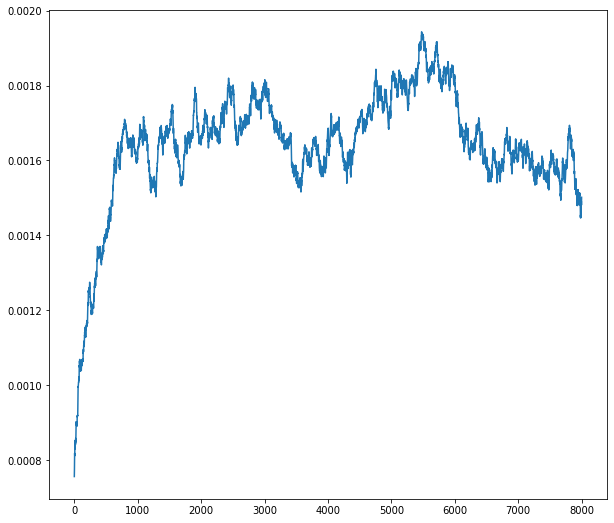

In [32]:
plt.plot( rhocov )

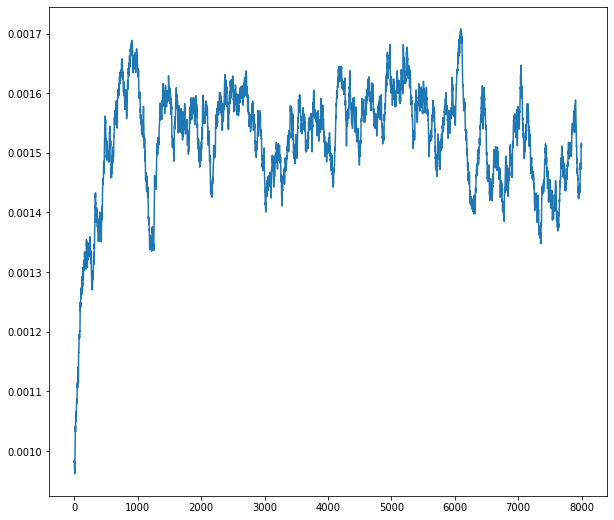

In [33]:
plt.plot( rhomev )

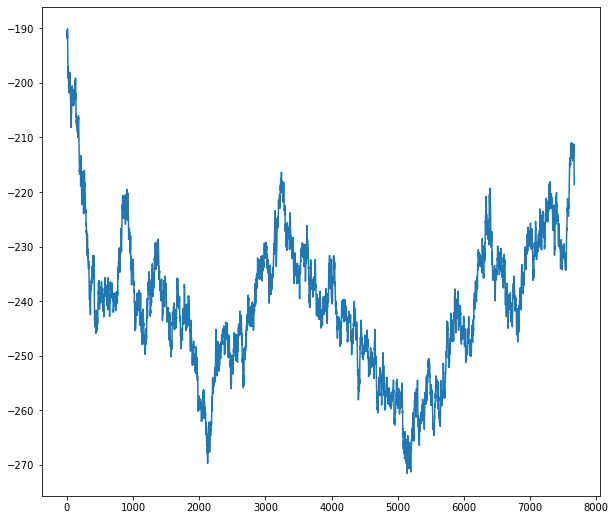

In [34]:
plt.plot( Env[ Env < -190] )

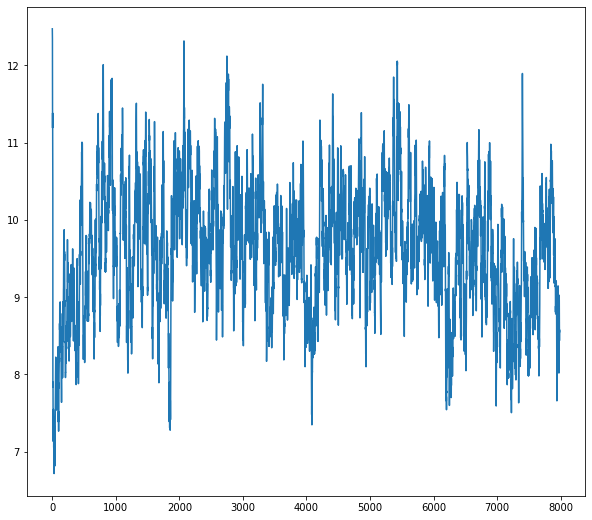

In [42]:
plt.plot( Pv[Pv < 13 ] )

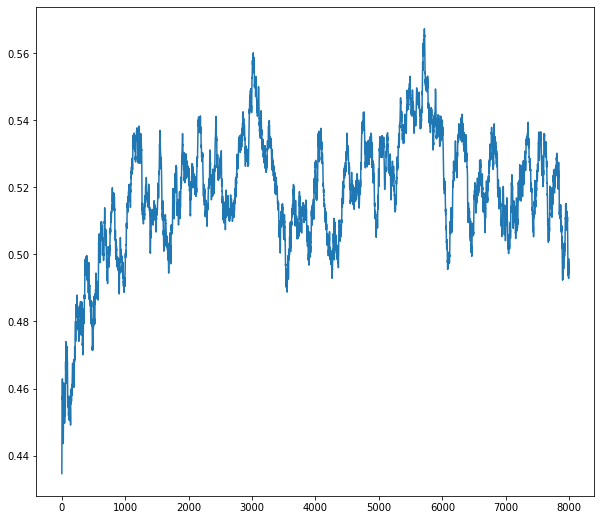

In [36]:
plt.plot( rhocov/(rhocov + rhomev) )

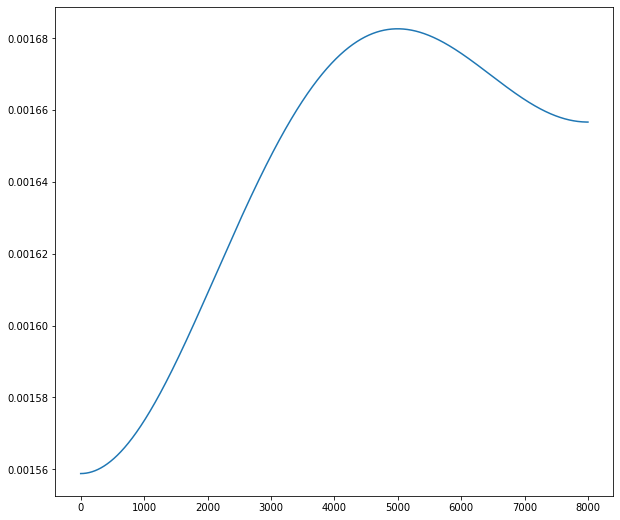

In [37]:
ynew = gaussian_filter1d( rhocov, sigma=2000)
plt.plot( ynew )

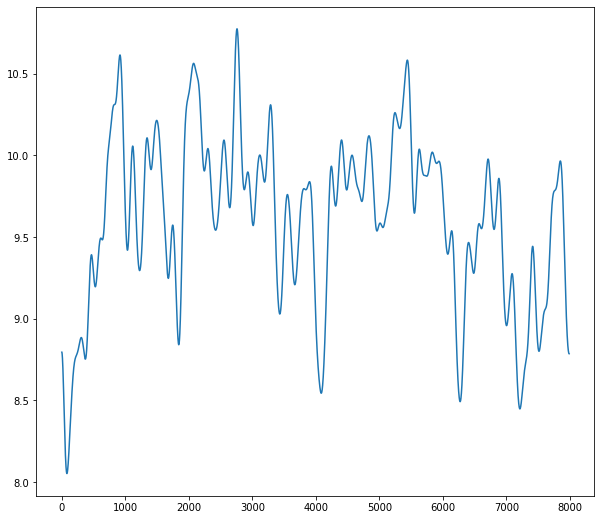

In [38]:
ynew = gaussian_filter1d( Pv[Pv <20], sigma=40)
plt.plot( ynew )

In [ ]:
ynew = gaussian_filter1d( Env[ Env < -190], sigma=40)
plt.plot( ynew )

In [ ]:
output = pd.DataFrame()
output['rhoco'] = rhocov
output['rhome'] = rhomev
output['En'] = Env
output['P'] = Pv

In [ ]:
output.to_csv('one_run.csv')

In [ ]:
plt.plot( rhocov/(rhocov+rhomev))